# https://www.doubao.com/thread/wf2d03979443c62a7

# 导入库

In [311]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [312]:
df_train = pd.read_csv("../data/nlp-getting-started/train.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 分析数据

### 缺失值
通过数据探查可见，location（推文发布地点）字段的缺失率约为 33%，意味着近 1/3 的样本未记录发布地点信息；而核心文本字段text无缺失，keyword（推文中的关键词）字段缺失率极低（仅 0.8%），整体数据质量符合文本分类任务的基础要求，但location字段的高缺失率需在后续预处理中重点处理（如通过 “Unknown” 填充或结合业务逻辑判断是否保留该字段）。

In [313]:
pd.DataFrame(df_train.isna().mean())



,0
id,0.000000
keyword,0.008013
location,0.332720
text,0.000000
target,0.000000


### keyword 分析
- 数据中发现 keyword 字段存在大量 %20 字符（这是 URL 编码中对空格的表示），后续预处理会统一将其替换为空格，以还原关键词的真实语义（如将 “typhoon%20warning” 还原为 “typhoon warning”）。
- 从类别分布来看，keyword 的频次呈现较均衡的特征（多数类别出现次数在 10-45 次之间，共 222 个独特值），无极端高频或低频的主导性关键词。
- 进一步分析发现，部分 keyword 与目标变量 target 存在强关联性：例如 “typhoon”（台风）对应的样本中，真实灾害（target=1）的占比显著偏高，这类关键词可作为模型判断的重要参考特征。

In [314]:
print(df_train["keyword"].unique()[:20])

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze']


In [315]:
temp = df_train["keyword"].apply(lambda x:str(x).replace("%20"," ").lower())
pd.DataFrame(temp.value_counts())



,count
keyword,
nan,61
fatalities,45
deluge,42
armageddon,42
damage,41
...,...
forest fire,19
epicentre,12
threat,11


In [316]:
crosstab_df_keyword = pd.crosstab(
    index=df_train["keyword"],  # 行索引：keyword唯一值
    columns=df_train["target"],  # 列索引：target（0或1）
    margins=True,  # 增加"All"列，显示每个keyword的总样本数
    margins_name="总计"  # 自定义"All"的名称为"总计"
)

# 重命名列索引（更直观）
crosstab_df_keyword.columns = ["非灾害（0）", "真实灾害（1）", "总计"]

print("以keyword为行、target为列的交叉表：")
pd.DataFrame(crosstab_df_keyword)

以keyword为行、target为列的交叉表：


,非灾害（0）,真实灾害（1）,总计
keyword,,,
ablaze,23,13,36
accident,11,24,35
aftershock,34,0,34
airplane%20accident,5,30,35
ambulance,18,20,38
...,...,...,...
wounds,23,10,33
wreck,30,7,37
wreckage,0,39,39


In [317]:
crosstab_df_keyword["真实灾害占比（1）"] = crosstab_df_keyword["真实灾害（1）"] / crosstab_df_keyword["总计"]
pd.DataFrame(crosstab_df_keyword.sort_values(by="真实灾害占比（1）"))[-10:]

,非灾害（0）,真实灾害（1）,总计,真实灾害占比（1）
keyword,,,,
rescuers,3,32,35,0.914286
bombing,2,27,29,0.931034
suicide%20bomber,1,30,31,0.967742
suicide%20bombing,1,32,33,0.969697
typhoon,1,37,38,0.973684
oil%20spill,1,37,38,0.973684
outbreak,1,39,40,0.975000
debris,0,37,37,1.000000
derailment,0,39,39,1.000000


### location 分析
- 数据探查显示 location 字段缺失率较高（约 33%），是核心字段中缺失最严重的特征；在有效记录中，“usa”（美国）是出现频次最高的地点，反映样本地理分布存在一定集中性。
- 进一步关联目标变量发现，特定地区的 location 与 target 存在明显相关性：例如标注为 “mumbai”（孟买）或 “india”（印度）的样本中，真实灾害（target=1）的占比显著高于整体平均水平，这类地区相关的 location 信息可作为辅助判断灾害的参考特征。

In [318]:
print(df_train["location"].unique()[:20])

[nan 'Birmingham' 'Est. September 2012 - Bristol' 'AFRICA'
 'Philadelphia, PA' 'London, UK' 'Pretoria' 'World Wide!!'
 'Paranaque City' 'Live On Webcam' 'milky way' 'GREENSBORO,NORTH CAROLINA'
 'England.' 'Sheffield Township, Ohio' 'India' 'Barbados' 'Anaheim'
 'Abuja' 'USA' 'South Africa']


In [319]:
temp = df_train["location"].apply(lambda x:str(x).replace("%20"," ").lower())
pd.DataFrame(temp.value_counts())[:20]



,count
location,
nan,2533
usa,104
new york,75
united states,50
london,49
canada,33
worldwide,31
nigeria,31
uk,30


In [320]:
crosstab_df_location = pd.crosstab(
    index=df_train["location"],  # location
    columns=df_train["target"],  # 列索引：target（0或1）
    margins=True,  # 增加"All"location
    margins_name="总计"  # 自定义"All"的名称为"总计"
)

# 重命名列索引（更直观）
crosstab_df_location.columns = ["非灾害（0）", "真实灾害（1）", "总计"]

print("location")
pd.DataFrame(crosstab_df_location.sort_values(by="总计",ascending=False))


location


,非灾害（0）,真实灾害（1）,总计
location,,,
总计,2884,2196,5080
USA,37,67,104
New York,55,16,71
United States,23,27,50
London,29,16,45
...,...,...,...
"Quantico Marine Base, VA.",1,0,1
"Amman, Jordan",0,1,1
"Amman,Jordan",0,1,1


In [321]:
crosstab_df_location["真实灾害占比（1）"] = crosstab_df_location["真实灾害（1）"] / crosstab_df_location["总计"]
pd.DataFrame(crosstab_df_location[crosstab_df_location["总计"]>10].sort_values(by="真实灾害占比（1）"))


,非灾害（0）,真实灾害（1）,总计,真实灾害占比（1）
location,,,,
NYC,10,2,12,0.166667
Everywhere,12,3,15,0.200000
Florida,11,3,14,0.214286
New York,55,16,71,0.225352
Kenya,15,5,20,0.250000
United Kingdom,10,4,14,0.285714
"Los Angeles, CA",18,8,26,0.307692
London,29,16,45,0.355556
Seattle,7,4,11,0.363636


### target 分析
- 样本分布相对均衡。


In [322]:
pd.DataFrame(df_train["target"].value_counts())

,count
target,
0,4342
1,3271


### text 分析

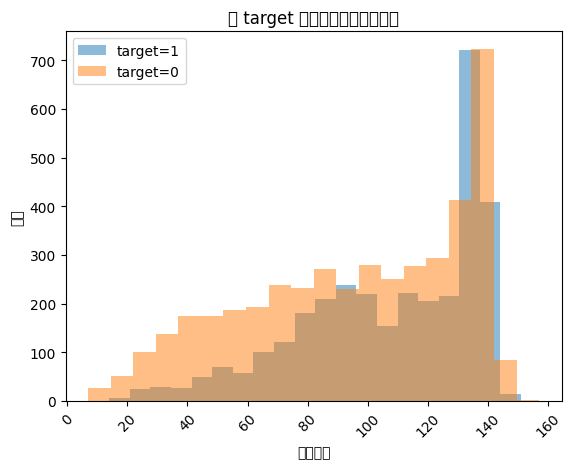

In [323]:
# 计算文本长度
text_len = df_train["text"].apply(lambda x: len(x))

# 获取 target 的唯一值
target_values = df_train['target'].unique()

# 为每个 target 值绘制直方图
for value in target_values:
    subset_text_len = text_len[df_train['target'] == value]
    plt.hist(subset_text_len, bins=20, alpha=0.5, label=f'target={value}')

plt.xlabel('文本长度')
plt.xticks(rotation=45)
plt.ylabel('频数')
plt.title('按 target 分组的文本长度直方图')
plt.legend()
plt.show()

In [324]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 下载nltk资源（首次运行需执行）
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# 初始化工具
stop_words = set(stopwords.words('english'))  # 英语停用词表
lemmatizer = WordNetLemmatizer()  # 词形还原工具

def clean_text(text):
    # 1. 转为小写
    text = text.lower()
    
    # 2. 移除URL（如http://xxx、https://xxx）
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 3. 移除@用户和#话题（如@FEMA、#Hurricane）
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # 4. 移除数字和特殊字符（只保留字母、空格和必要标点）
    text = re.sub(r'[^a-z\s]', ' ', text)  # 非字母替换为空格
    
    # 5. 移除多余空格（多个空格合并为一个）
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 6. 分词并过滤停用词、单字母词
    words = text.split()
    words = [word for word in words 
             if word not in stop_words  # 去停用词
             and len(word) > 1]  # 去单字母词（如a、i）
    
    # 7. 词形还原（如floods→flood，hurricanes→hurricane）
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # 8. 重新组合为句子
    return ' '.join(words)

# 假设已加载数据并预处理文本（clean_text 为清洗后的文本列）
clean_text = df_train["text"].apply(clean_text)

# 放宽过滤条件，保留更多词
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=50000,  # 增加保留的词量
    min_df=2,  # 至少在2条推文中出现过才保留
    max_df=0.9  # 过滤在90%以上推文中都出现的词（如通用词）
)
tfidf_matrix = tfidf.fit_transform(clean_text)

# 计算每个词在灾害/非灾害推文中的平均TF-IDF得分
words = tfidf.get_feature_names_out()
disaster_mask = (df_train["target"] == 1).astype(int)  # 形状为 (n_samples,) 的整数Series
non_disaster_mask = (df_train["target"] == 0).astype(int)  # 形状为 (n_samples,) 的整数Series

disaster_tfidf = tfidf_matrix[disaster_mask].mean(axis=0).A1
non_disaster_tfidf = tfidf_matrix[non_disaster_mask].mean(axis=0).A1

# 对比展示
tfidf_df = pd.DataFrame({
    "word": words,
    "disaster_avg_tfidf": disaster_tfidf,
    "non_disaster_avg_tfidf": non_disaster_tfidf
}).sort_values("disaster_avg_tfidf", ascending=False).head(10)
print("灾害推文Top10高TF-IDF词：")
print(tfidf_df[["word", "disaster_avg_tfidf"]])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


灾害推文Top10高TF-IDF词：
         word  disaster_avg_tfidf
1138     deed            0.308230
1774  forgive            0.308230
119     allah            0.290417
655    canada            0.246252
3634   reason            0.225686
2497       la            0.220705
3010     near            0.195949
1771   forest            0.191991
8     abcnews            0.000000
5049     yall            0.000000


## 特征工程

In [325]:
df_train = pd.read_csv("../data/nlp-getting-started/train.csv")
df_test = pd.read_csv("../data/nlp-getting-started/test.csv")

In [326]:
def process_location(df):
    df["location"].fillna("unknown",inplace=True)
    df['location'] = df['location'].apply(lambda x: "unknown" if  x not in ['NYC', 'Everywhere', 'Florida', 'New York', 'Kenya', 'Washington, D.C.', 'Washington, DC', 'Earth', 'Nigeria', 'India','Mumbai'] else x)
    df["location"] = df["location"].apply(lambda x:str(x).lower())
    return df
df_train = process_location(df_train)
df_test = process_location(df_test)

In [327]:
def process_keywords(df):
    df["keyword"].fillna("unknown",inplace=True)
    df["keyword"] = df["keyword"].apply(lambda x:"unknown" if x not in ['rescuers','bombing','suicide%20bomber','suicide%20bombing','typhoon','oil%20spill','outbreak','debris','derailment','wreckage'] else x)
    df["keyword"] = df["keyword"].apply(lambda x:str(x).lower().replace("%20"," "))
    return df
df_train = process_keywords(df_train)
df_test = process_keywords(df_test)

In [328]:
def clean_text(text):
    # 去除URL链接
    text = re.sub(r'http\S+', '', text)
    # 去除特殊字符，只保留字母和数字
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = text.strip()
    return text

def process_text(df):
    df["tagInText"] = df["text"].apply(lambda x:"#" in x)
    df["httpInText"] = df["text"].apply(lambda x:"http" in x)
    df["text_cleaned"] = df["text"].apply(lambda x:clean_text(x))
    return df

df_train = process_text(df_train)
df_test = process_text(df_test)

# 保存

In [329]:
sizetrain  = df_train.shape[0]
sizetest = df_test.shape[0]
df_all = pd.concat([df_train,df_test])
df_ohe = pd.get_dummies(df_all,columns=["keyword","location"])
df_ohe = df_ohe[['tagInText', 'httpInText', 
       'keyword_bombing', 'keyword_debris', 'keyword_derailment',
       'keyword_oil spill', 'keyword_outbreak', 'keyword_rescuers',
       'keyword_suicide bomber', 'keyword_suicide bombing', 'keyword_typhoon',
       'keyword_wreckage', 'location_earth',
       'location_everywhere', 'location_florida', 'location_india',
       'location_kenya', 'location_mumbai', 'location_new york',
       'location_nigeria', 'location_nyc',
       'location_washington, d.c.', 'location_washington, dc', 'text_cleaned', 'target']]
for col in df_ohe.columns:
    if col != "text_cleaned":
        df_ohe[col] = df_ohe[col].astype(float)

df_train = df_ohe[:sizetrain]
df_test = df_ohe[sizetrain:]
df_test.drop(columns=["target"],inplace=True)




In [330]:
df_train

,tagInText,httpInText,keyword_bombing,keyword_debris,keyword_derailment,keyword_oil spill,keyword_outbreak,keyword_rescuers,keyword_suicide bomber,keyword_suicide bombing,...,location_india,location_kenya,location_mumbai,location_new york,location_nigeria,location_nyc,"location_washington, d.c.","location_washington, dc",text_cleaned,target
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,our deeds are the reason of this earthquake ma...,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,forest fire near la ronge sask canada,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,all residents asked to shelter in place are be...,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13000 people receive wildfires evacuation orde...,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,just got sent this photo from ruby alaska as s...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,two giant cranes holding a bridge collapse int...,1.0
7609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ariaahrary thetawniest the out of control wild...,1.0
7610,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,m194 0104 utc5km s of volcano hawaii,1.0
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,police investigating after an ebike collided w...,1.0


In [331]:
df_train.to_csv("../data/train_cleaned.csv",index=False)
df_test.to_csv("../data/test_cleaned.csv",index=False)